# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

##### TODO: Introduction

In [2]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
                                  avg, from_unixtime, split, min, max, lit, mean
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

from pyspark.sql.types import IntegerType, TimestampType
import datetime
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, hour, date_format, substring

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sb

In [3]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [4]:
# Set time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

### Data set size and schema

In [6]:
# Dataset size
print(f'Row count: {original_count}')
print(f'Column count: {len(data.columns)}')

Row count: 286500
Column count: 18


In [7]:
# Schema
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Columns description

In [8]:
def unique(data, column):
    """Return unique values with row count of a given column in the data set.
    
    Args:
        data (DataFrame): The data set. 
        column (str): The name of a target column.

    Returns:
        DataFrame: A dataframe query sorted by count descending.
    """
    return data.groupby(column).count().sort(desc('count'))

**artist**: Interpreter(s) of a song. Is given only when the music is played (on *NextSong* event).

**auth**: The authentication level

In [9]:
unique(data, 'auth').show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



**firstName**: The first name of a user

**gender**: The gender of a user

In [104]:
unique(data, 'gender').show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  null|  8346|
+------+------+



**itemInSession**: The zero-based index of a log event in a sesion

In [59]:
data.where(data.sessionId == 31).select('ts', 'itemInSession', 'page').sort('ts').show(5)

+-------------+-------------+---------+
|           ts|itemInSession|     page|
+-------------+-------------+---------+
|1539003534000|            0| NextSong|
|1539003736000|            1| NextSong|
|1539003932000|            2| NextSong|
|1539003933000|            3|Thumbs Up|
|1539004195000|            4| NextSong|
+-------------+-------------+---------+
only showing top 5 rows



**lastName**: The last name of a user

**length**: The length of a song (in seconds)

**level**: The subscription level of a user

In [105]:
unique(data, 'level').show()

+-----+------+
|level| count|
+-----+------+
| paid|228162|
| free| 58338|
+-----+------+



**location**: The location of a user (containing *city*, *state*)

In [106]:
unique(data, 'location').show(5, False)

+-------------------------------------+-----+
|location                             |count|
+-------------------------------------+-----+
|Los Angeles-Long Beach-Anaheim, CA   |30131|
|New York-Newark-Jersey City, NY-NJ-PA|23684|
|Boston-Cambridge-Newton, MA-NH       |13873|
|Houston-The Woodlands-Sugar Land, TX |9499 |
|null                                 |8346 |
+-------------------------------------+-----+
only showing top 5 rows



**method**: The http request method

In [107]:
unique(data, 'method').show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



**page**: The type of user interaction (or event log type)

In [108]:
unique(data, 'page').show(30, False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Home                     |14457 |
|Thumbs Up                |12551 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Login                    |3241  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Help                     |1726  |
|Settings                 |1514  |
|About                    |924   |
|Upgrade                  |499   |
|Save Settings            |310   |
|Error                    |258   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
|Register                 |18    |
|Submit Registration      |5     |
+-------------------------+------+



**registration**: The timestamp of a user registration

**sesionId**: The identifier of a user session

**song**: The name of a song

In [72]:
unique(data.where(data.userId == 100001), 'song').show(5, False)

+-----------------+
|song             |
+-----------------+
|null             |
|Alejandro        |
|Ali In The Jungle|
|All I Ever Wanted|
|All My Friends   |
+-----------------+
only showing top 5 rows



**status**: The http response status code

In [109]:
unique(data, 'status').show(5, False)

+------+------+
|status|count |
+------+------+
|200   |259812|
|307   |26430 |
|404   |258   |
+------+------+



**ts**: The timestamp of an event log

**userAgent**: The user's agent used to access the streaming service 

**userId**: The identifier of a user

### Duplicate rows

In [10]:
# Any duplicate rows? - No
print(f'Duplicate rows: {data.count() - data.dropDuplicates().count()}')

Duplicate rows: 0


### Missing values

In [11]:
def filter_missing(data, column):
    """Returns rows with missing values for a given column where a missing value
    is either null or empty string.
    
    Args:
        data (DataFrame): The data set.
        column (str): The name of a target column.    
        
    Returns:
        DataFrame: A dataframe query with missing values.
    """
    return data.where((col(column).isNull()) | (col(column) == ''))

def show_missing(data):
    """Shows the count of missing values for every column in a given data set.
    
    Args:
        data (DataFrame): The data set.
        
    Returns:
        None
    """
    for field in data.schema:
        print(f'{field.name}: {filter_missing(data, field.name).count()}')

In [10]:
show_missing(data)

artist: 58392
auth: 0
firstName: 8346
gender: 8346
itemInSession: 0
lastName: 8346
length: 58392
level: 0
location: 8346
method: 0
page: 0
registration: 8346
sessionId: 0
song: 58392
status: 0
ts: 0
userAgent: 8346
userId: 8346


Check if 8346 missing values in the user-related columns (*firstName*, *gender*, *lastName*, *location*, *registration*, *userAgent*, *userId*) belong to the same rows:

In [12]:
class Missing:
    """A helper class to simplify filtering the missing values.  
    
    Attributes:
        missing_data: A dataframe query that is built by filter_missing method.   
    """
    missing_data = None
    
    def __init__(self, data):
        self.missing_data = data
        
    def filter_missing(self, name):
        """A method that filters the missing values.
        
        We can use this method in a consecutive manner.
        
        Args:
            name (str): The name of a column to filter.
            
        Returns:
            DataFrame: A dataframe query with missing values.
        """
        self.missing_data = filter_missing(data, name) 
        return self  

In [13]:
m = Missing(data) \
    .filter_missing('userId') \
    .filter_missing('firstName') \
    .filter_missing('lastName') \
    .filter_missing('gender') \
    .filter_missing('location') \
    .filter_missing('registration') \
    .filter_missing('userAgent')
print(f'Missing count: {m.missing_data.count()}')

Missing count: 8346


As the filtering criterion contains the logical conjunction of all user-related columns and the count result of missing values is the same as when a single user-related column is filtered we may conclude that the missing values occur *in the same rows*. This behaviour is in tune with the logic which tells us that if a user identifier is missing then also all the related user attributes should be missing too. 

**What kind of a user has missing attributes?**

In [75]:
filter_missing(data, 'userId').select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [76]:
filter_missing(data, 'userId').select('page').dropDuplicates().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



Clearly, the missing user is an **unregistered** user. Then, since our target is a *churned* user which is a *registered* user, it is also clear that if we remove the rows with missing users *we will not remove any churned user*.

In [14]:
# Remove rows with the missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))
show_missing(data) 

artist: 50046
auth: 0
firstName: 0
gender: 0
itemInSession: 0
lastName: 0
length: 50046
level: 0
location: 0
method: 0
page: 0
registration: 0
sessionId: 0
song: 50046
status: 0
ts: 0
userAgent: 0
userId: 0


In [14]:
# Check count of deleted rows - OK
original_count - data.count()

8346

### Remove unrelevant columns

We identify 2 columns that are not relevant for our analysis: *firstName* and *lastName*. In the perfect naming, the combination of this two columns would be the user's candidate key (which is actually the case with our mini data set - check below). However, we already have the unique identifier of a user - **userId**, so this two columns do not deliver any new information relevant for our analysis that is not already contained in the *userId* attribute.

In [15]:
# How many different keys (firstName, lastName) exist in our dataset?
data.select('firstName', 'lastName').dropDuplicates().count()

225

In [16]:
# Check if a composite key firstName-lastName is associated to exactly one userId
data.select('firstName', 'lastName', 'userid') \
    .dropDuplicates() \
    .groupby('firstName', 'lastName') \
    .count() \
    .where(col('count') > 1) \
    .count()

0

In [15]:
# Drop redundant columns
data = data.drop('firstName')
data = data.drop('lastName')

### Convert unix timestamp into TimestampType  (*ts*)

In [16]:
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', gender='M', itemInSession=50, length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', tsDate=datetime.datetime(2018, 10, 1, 2, 1, 57))]

### Split location into *Place* and *State*

The location column contains *place* and *state*. Let's split the composed information into 2 features and drop the original column.

In [17]:
data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

In [18]:
# Schema after the cleaning is done
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [19]:
# Set plot's figure size
def set_plot_size(width, height):
    """Set plot's figure size.
    
    This function does not contribute anything special to the code here.
    (It is just a small coding simplification that I myself find useful.)
    
    Args:
        width (int): The width of a figure.
        height (int): The height of a figure.
        
    Returns:
        Figure: The figure instance.
    """
    return plt.figure(figsize = [width, height]);

def get_categories(data, column):
    """Creates a list of column's categories.
    
    Args:
        data (DataFrame): The data set. 
        column (str): The name of a target column.

    Returns:
        list: A list of column categories. 
    """   
    return [str(row[column]) for row in unique(data, column).collect()]

## Preliminary Analysis

In [94]:
# Count of unique users
data.select('userId').dropDuplicates().count()

225

In [96]:
# Count of unique sessions
data.select('sessionId').dropDuplicates().count()

2312

In [99]:
# Total observation period
data.select(to_date(min('tsDate')).alias('MinDate'), to_date(max('tsDate')).alias('MaxDate')).show()

+----------+----------+
|   MinDate|   MaxDate|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



### Log level
A *log level* is a level without any aggregation. All rows of our data set belong to the log level.

#### Log level: *Level*, *Status*

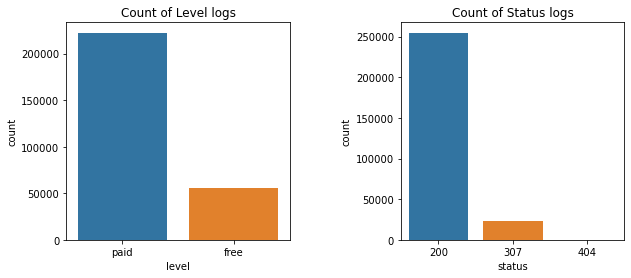

In [20]:
fig = set_plot_size(10, 4);
plt.subplots_adjust(wspace=0.5)

# 1. Count log events by level categories (paid, free) 
df = data.select('level').toPandas()
plt.subplot(1, 2, 1)
sb.countplot(data = df, x = 'level');
ax = plt.gca()
ax.set_title('Count of Level logs');

# 2. Count log events by status categories
df = data.select('status').toPandas()
plt.subplot(1, 2, 2)
sb.countplot(data = df, x = 'status');
ax = plt.gca()
ax.set_title('Count of Status logs');

#### Log level: *page*

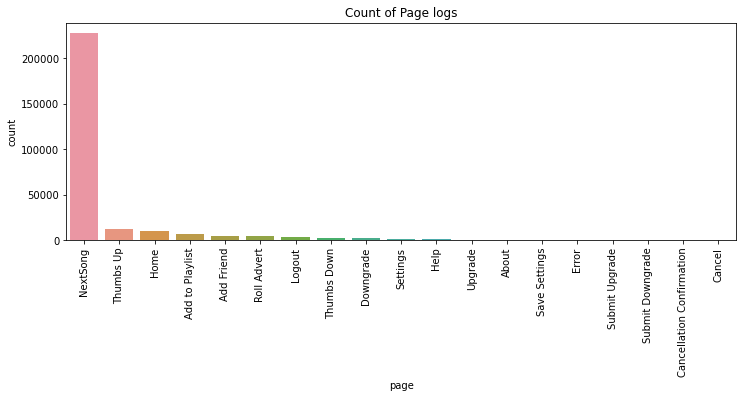

In [114]:
set_plot_size(12, 4)
df = data.select('page').toPandas()
sb.countplot(data = df, x = 'page', order = df['page'].value_counts().index);
plt.xticks(rotation = 90);
ax = plt.gca()
ax.set_title('Count of Page logs');

### User level
A *user level* is a level where data is aggregated by *userId*. We have already met the *user-related* columns which are *userId*-dependent since their value does not change if a log event changes unless the *userId* attribute changes. 

In [47]:
def plot_hist_with_boxplot(df, column, title, bins=15, ):
    """Plots a histogram with boxplot.
    
    Args:
        df (pandas DataFrame): The data set.
        column (str): The name of a target column.  
        title (str): The title of a plot.
        bins (int, optional): The number of histogram's bins.
        
    Returns:
        None
    """
    # Output statistics 
    print(df.describe())
    
    fig = set_plot_size(12, 4);
    spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[5, 1])
    plt.subplots_adjust(hspace=0.3)

    # Plot histogram + boxplot
    ax0 = fig.add_subplot(spec[0])
    ax0.hist(df[column], bins=15)
    ax0.set_title(title);
    plt.xlabel(column)
    plt.ylabel('frequency')
    ax1 = fig.add_subplot(spec[1])
    ax1.boxplot(df[column])

    plt.show()

#### User level: *Gender*

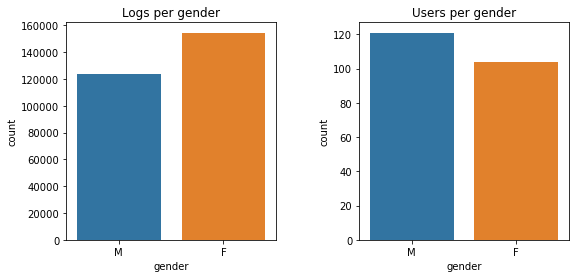

In [200]:
set_plot_size(9, 4);
plt.subplots_adjust(wspace=0.4)

# 1. Count logs per gender
df_gender_logs = data.select('gender').toPandas()
plt.subplot(1, 2, 1)
sb.countplot(data = df_gender_logs, x = 'gender', order = ['M','F']).set_title('Logs per gender');

# 2. Count users per gender
df_gender_users = data.groupby('userId', 'gender').count().toPandas()
plt.subplot(1, 2, 2)
sb.countplot(data = df_gender_users, x = 'gender', order = ['M','F']).set_title('Users per gender');

On one side *we have more male users*, on the other side *the female users are more active*.

#### User level: *State*

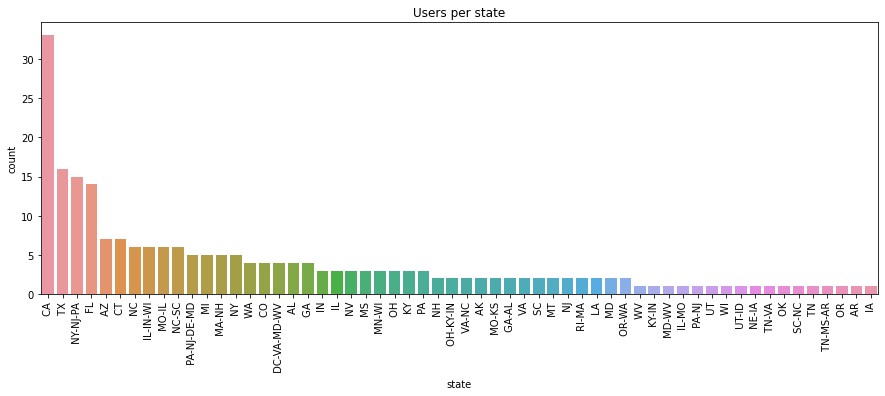

In [201]:
# Count users per state
df_user_state = data.select('userId', 'state').dropDuplicates().toPandas()

set_plot_size(15, 5);
data_order = df_user_state['state'].value_counts().index
sb.countplot(data = df_user_state, x = 'state', order = data_order).set_title('Users per state')
plt.xticks(rotation = 90);
plt.show()

#### User level: *Logs per user*

             count
count   225.000000
mean   1236.240000
std    1329.531716
min       6.000000
25%     296.000000
50%     848.000000
75%    1863.000000
max    9632.000000


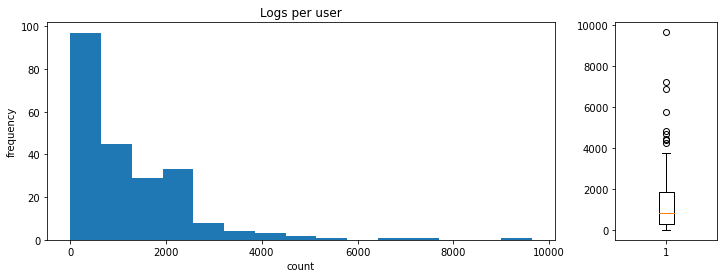

In [48]:
df_user_logs = data.groupby('userId').count().toPandas()
plot_hist_with_boxplot(df_user_logs, 'count', 'Logs per user')

The distribution of logs per user is **right-skewed**. Some extreme outliers can be detected. We may expect that, in general, our statistical model will be negatively affected by these outliers.

#### User level: *Sessions per user*

            count
count  225.000000
mean    14.115556
std     14.646885
min      1.000000
25%      6.000000
50%     10.000000
75%     18.000000
max    107.000000


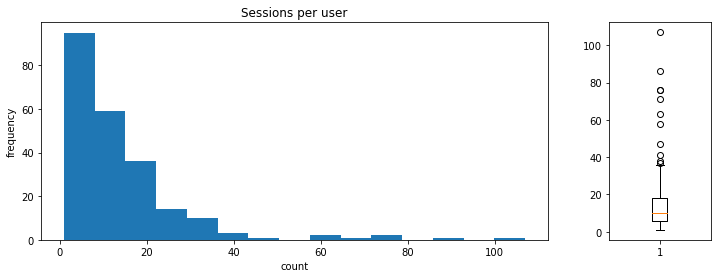

In [49]:
df_user_sessions = data.groupby('userId', 'sessionId').count().groupby('userId').count().toPandas()
plot_hist_with_boxplot(df_user_sessions, 'count', 'Sessions per user')

The distribution of sessions per user is similar to the distribution of logs per user - *right-skewed*. It is not surprising,  both distributions has a *lower bound* and the data with a lower bound tends to be right-skewed.

### Session level
A *session level* is a level where data is aggregated by *userId*, *sessionId*. Note that the *sessionId* attribute is not a unique identifier of a session; it is unique only for a single user, however, as alone cannot be used in a cross-user context.

In [119]:
# Check if two or more users can share the same sessionId - YES
data \
    .select('userId', 'sessionId').dropDuplicates() \
    .groupby('sessionId').count() \
    .where(col('count') > 1) \
    .show(5)

+---------+-----+
|sessionId|count|
+---------+-----+
|       65|    4|
|      418|    2|
|      191|    3|
|      270|    3|
|      293|    3|
+---------+-----+
only showing top 5 rows



#### Session level: *Session duration (in min)*

          duration
count  3176.000000
mean    299.518755
std     390.281555
min       0.000000
25%      58.129167
50%     160.541667
75%     381.283333
max    4455.083333


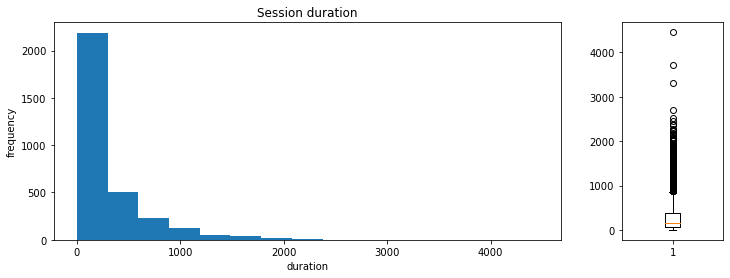

In [53]:
df_session_duration = data.groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .select('duration').toPandas()
plot_hist_with_boxplot(df_session_duration, 'duration', 'Session duration')

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [21]:
# Check count of cancelled users
cancelled = data.where(data.page == 'Cancellation Confirmation').select('userId').dropDuplicates()
cancelled.count()

52

In [22]:
# Check count of downgraded users
downgraded = data.where(data.page == 'Submit Downgrade').select('userId').dropDuplicates()
downgraded.count()

49

In [23]:
# Check count of users that downgrade AND cancel the subscription
downgraded.intersect(cancelled).count()

9

#### Decision about which type of churned users to observe

There are **52** users out of 225 that cancelled the subscription and **49** users that downgraded. **9** users did both things. Already the number of all users is low, but with so small number of churned users it will be very difficult to create a reliable statistical model that will predict similarly in cases of different random data splits (different *seeds*). 

It could help us if the two churn types can be observed as a *single type*. In that case we would almost duplicate the churn sample. However, before unite both types we have to check if the *cancelled* and *downgraded* users share the **similar statistics**  relevant for our model.

             count
count    52.000000
mean    862.769231
std     852.262378
min      11.000000
25%     208.750000
50%     576.000000
75%    1154.000000
max    3603.000000


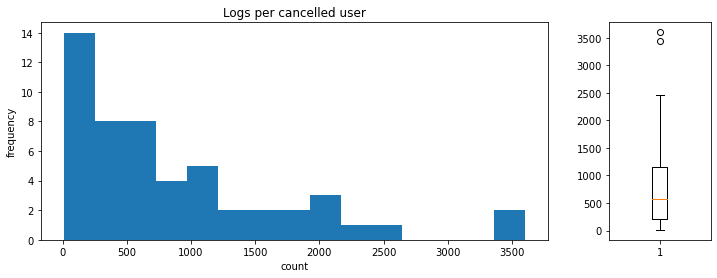

             count
count    49.000000
mean   2176.571429
std    1904.991175
min     262.000000
25%     977.000000
50%    1570.000000
75%    2335.000000
max    9632.000000


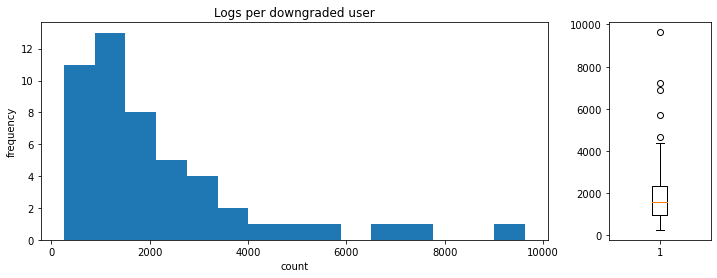

In [84]:
df_user_logs_cancelled = data \
    .where(data.userId.isin([row.userId for row in cancelled.collect()])) \
    .groupby('userId').count().toPandas()

df_user_logs_downgraded = data \
    .where(data.userId.isin([row.userId for row in downgraded.collect()])) \
    .groupby('userId').count().toPandas()
           
plot_hist_with_boxplot(df_user_logs_cancelled, 'count', 'Logs per cancelled user')
plot_hist_with_boxplot(df_user_logs_downgraded, 'count', 'Logs per downgraded user')

Well, the *logs per user* statistics of both churn types *differs considerebly*. All the statisticals values shows huge discrepancies: the *cancelled* users have **863** logs on average, the *downgraded* users generates much more logs - **2177** on average which is 2.5 times higher value. The similar behaviour can be found with other statistical values.

The *log count statistics* is the most basic statistics we can make since it uses the *unaggregated source data*. If the two types of churned users do not share the same basic statistics then it is very likely that we face the discrepancies on certain aggregation levels. As we persue a goal to predict well we opt **not to unite both types**. 

We will follow the Udacity suggestion to focus on the first type - the **cancelled** users. Later on when we'll move to the big data set (on cluster) we might consider incorporating the downgraded users in order to check if this initial assumption about the *two distinctive churn types* that we are making here is correct. 

In [57]:
def get_users(churn):
    """Returns unique users of a specified churn group.
    
    Args:
        churn (int): The churn column with Boolean values (0 - non-churned, 1 - churned).
        
    Returns:
        DataFrame: A dataframe query.
    """
    return data.where(data.churn == churn).select('userId').dropDuplicates()

#### Churn of cancelled users

We'll label the *churned* users by **1**, and the *non-churned* users by **0**. Similarly, the variables with the suffix "1" will represent the *churned* users while the variables with the suffix "0" will represent the *non-churned* users. 

According to our terminology, the distinction between the **churned** and **non-churned** users denominated as "churn group" (also *classification* group) shouldn't be confused with the distinction between the **cancelled** and **downgraded** users denominated as "churn type".

In [25]:
# Label churned (canceled) users
cancelled_uids = [row.userId for row in cancelled.collect()];
set_churn = udf(lambda x: 1 if x in cancelled_uids else 0, IntegerType())
data = data.withColumn('churn', set_churn('userId'))
print(f"Churned users who cancelled subscription: {get_users(1).count()}")

Churned users who cancelled subscription: 52


In [27]:
# Add [userRowId] column that assigns a 1-based index to every user's log ordered by [ts]
w =  Window.partitionBy(data.userId).orderBy('ts', 'itemInSession')
data = data.withColumn('userRowId', row_number().over(w))

# Add [userRowDescId] column that assigns a 1-based index to every user's log ordered by [ts] descending.
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc(), col('itemInSession').desc())
data = data.withColumn('userRowDescId', row_number().over(w))

In [28]:
# Add lastLevel column
last_levels = dict()
for row in data.where(data.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
get_level = udf(lambda userId: last_levels[userId])
data = data.withColumn('lastLevel', get_level('userId'))
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free')]

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### General statistical method
Let us describe the *general statistical method* with its simple mathematics that will be used in any analysis throughout the project.

A certain **feature** $f$ of a user $x$

> $f(x)$

can be important for our learning model only if it can serve us to "distinguish well" between the two churn groups (*churned*, *non-churned*). We use a certain *aggregation* (or **group**) function $g$ like *mean*

> $g(f, y)$  

where *y* is a **churn group** (1 or 0) to determine if the feature $f$ "distinguish well" between the two churn groups. The group function is applied over the subset of users that belong to a specified group *y*. If the absolute value of a difference between the aggregation values is "big enough"

> diff = $|g(f, 1) - g(f, 0)|$ 

we can say that the feature $f$ "distinguish well". However, in order to determine if the value *diff* is "big enough" we have to normalize it. Let

> $v_1$ = $g(f, 1)$ and $v_2$ = $g(f, 0)$

Then a **ratio** of *churned* users (for a given feature $f$) is:

> $ratio_1$ = $\frac{v_1}{v_1 + v_0}$  

Similarly, a *share* of *non-churned* users is

> $ratio_0$ = $\frac{v_0}{v_1 + v_0}$  

Now, let us calculate the difference ($\Delta$) between the both ratios:

> $\Delta$ = $ratio_1$ - $ratio_0$ = $\frac{v_1 - v_0}{v_1 + v_0}$ 

which gives us a **ratio difference** with absolute values between 0 and 1. Note that we do not express the ratio difference as the *absolute value* since we want to preserve the sign which will tell as, if **positive**, that the feature $f$ for a group of churned users gives, on average - if *g* is a *mean* function, *higher values* than the same feature $f$ for a group of non-churned users, and, if **negative**, it gives *lower values*.
   
##### Delta threshold
Using the *delta* as a decisive factor for a feature selection is based on the idea that a certain feature is important for our model if and only if it can distinguish "well enough" beetwen the two churn groups. According to some preliminary tests we made we have seen that a feature can work well for our learning model if the **delta threshold** is set to

> $|\Delta| > 0.1$

which means that there should be **at least 10% of difference** between the churn group ratios in order **to select the feature for our learning model**. 

##### Rational remark

We are aware that this statistical approach as described above which will give us some orientation how to engineer and select features is not a waterproof method that will hit the target *for any feature whose delta fulfills the threshold condition*. After all, it is just a statistical method **applied over a single, isolated feature**, that is to say, we make a simple one-dimensional calculation using one feature while the process of machine learning is far more complex where it is very difficult to forsee which features will serve best - *before the model fitting is actually done*.     

In [58]:
# set the delta threshold
delta_threshold = 0.10

# label names of both classification groups
#label_names = ['churned', 'non-churned']

In [116]:
def get_churn_name(churn):
    """Maps churn values to churn names.
    
    Args:
        churn: The churn group (0 for churned and 1 for non-churned users).
        
    Returns:
        str: The name of a churn group.
    """
    if churn == 0:
        return 'non-churned'
    else:
        return 'churned'

def calc_ratio(df, column, feature=None):
    """Calculates the ratio of a feature.
    
    Args:
        df (pandas DataFrame): The data set.
        column (str): The name of a column with engineered feature values.
        feature (optional): The name of a column with original feature values.

    Returns:
        pandas DataFrame: The data set with a ratio column.  
    """
    if feature != None:  
        df = df.merge(df.groupby(feature).sum().reset_index(), on=feature, suffixes=['', '_sum'])
        df['ratio'] = df[column]/df[column + '_sum']
        df = df[['churn', feature, column, 'ratio']]
        df['churn_name'] = df['churn'].apply(get_churn_name)
        return df.sort_values(by=['churn'])
    else:
        df['ratio'] = df[column]/df.sum()[column]
        df = df[['churn', column, 'ratio']]
        df['churn_name'] = df['churn'].apply(get_churn_name)
        return df.sort_values(by='churn')   

In [117]:
def plot_ratio(df, title):
    """Plots the feature's ratio for both churn groups.
    
    Args:
        df (pandas DataFrame): The data set.
        title (str): The plot's title.
    Returns:
        None
    """      
    set_plot_size(4, 4)
    df2 = df.sort_values(by='ratio', ascending=True)
    labels = df['churn_name']
    plt.xticks(range(2), labels)
    plt.xticks(df2.churn, labels)
    plt.xlabel('')
    plt.ylabel('ratio')
    ratio_bars = plt.bar(range(2), df2['ratio'], width=0.7);
    ratio_bars[0].set_color('orange')
    ax = plt.gca()
    ax.set_title(title);
    plt.show()

In [118]:
def show_delta(df, column, feature, force_selection=False):
    """Calculates delta and print it.
    
    If delta is greater than delta_threshold the feature is selected.
    
    Args:
        df (pandas DataFrame): The data set.
        column (str): The name of a column with engineered feature values.
        feature (str): The feature name.
        force_selection (bool): If True then the feature is selected without evaluating the threshold condition. 
    Returns:
        None
    """
    # Get feature values for each classification group
    v1 = df[df.churn == 1][column].iloc[0]
    v0 = df[df.churn == 0][column].iloc[0]
    
    # Calc delta
    delta = (v1 - v0)/(v1 + v0)
    
    if (force_selection == True) or (abs(delta) > delta_threshold):
        print(f'Δ for {feature} feature: {round(delta, 4)} (SELECTED)')
    else:
        print(f'Δ for {feature} feature: {round(delta, 4)}')

#### Log level
We will calculate a share of logs with a selected feature for each target group (*churned*, *non-churned*).

In [46]:
# Count of churned/non-churned logs
count0 = data.where(data.churn == 0).count()
count1 = data.where(data.churn == 1).count()

#### Log level: *Average logs per churn group*

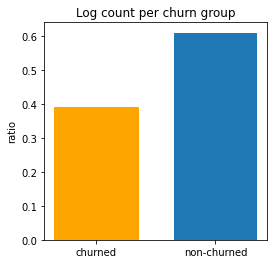

Δ for LogCount feature: -0.2197 (SELECTED)


In [119]:
logs_df = data \
    .groupby('churn', 'userId') \
    .count() \
    .groupby('churn') \
    .agg(avg('count').alias('avgLogs')) \
    .toPandas()
    
logs_df = calc_ratio(logs_df, 'avgLogs')
plot_ratio(logs_df, 'Log count per churn group')
show_delta(logs_df, 'avgLogs', 'LogCount')

In [ ]:
def calc_feature_ratio(feature):
    # calculate count of each category, per churn group
    df = data \
        .groupby('churn', feature) \
        .count() \
        .toPandas()
       
    totals = df.groupby('churn').sum()
    df = df.set_index('churn').join(totals, rsuffix='_total')
    df['share'] = df['count']/df['count_total']
    df = df.drop('count_total', axis=1)
    return df.reset_index()

#### Log level: *method*, *status*

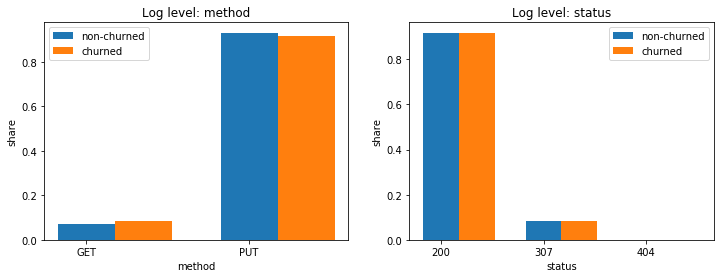

In [192]:
# Prepare data
log_method_df = calc_log_share('method')
log_status_df = calc_log_share('status')

set_plot_size(12, 4);

# 1. Method
plt.subplot(1, 2, 1)
plot_ratio(log_method_df, 'Log count per churn group')
plot_share(log_method_df, 'method', 'Log level: Method', 2)

# 2. Status
plt.subplot(1, 2, 2)
plot_share(log_status_df, 'status', 'Log level: Status')

plt.show()

### User level
We calculate a share of users with a selected feature for each target group.

#### Common variables and functions

In [95]:
# Count users for each churn group 
split = data.groupby('churn', 'userId').count()
user_count0 = split.where(split.churn == 0).count()
user_count1 = split.where(split.churn == 1).count()

In [152]:
get_user_total = udf(lambda x: user_count0 if x == 0 else user_count1)

# Calculate user share for each churn group
def calc_user_share(data, feature):
     return data \
        .withColumn('total', get_user_total('churn')) \
        .select('churn', 'total', 'userId', feature) \
        .dropDuplicates() \
        .groupby('churn', 'total', feature) \
        .count() \
        .withColumn('share', col('count')/col('total')) \
        .sort('churn', feature) \
        .toPandas()

#### User level: *Gender*

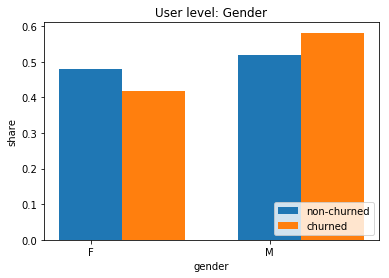

In [195]:
df_user_gender = calc_user_share(data, 'gender')
plot_share(df_user_gender, 'gender', 'User level: Gender', 4)

### <span style="color:red">Significant user interaction features</span>
 - Gender

#### User level: *Level*
Since a *level* is a **user-time dependent feature** we will observe here the level at the beginning of the observation period (*First level*) and the level at the end of the observation period (*Last level*). (Check the next analysis for user-time presentation of *level* data.)

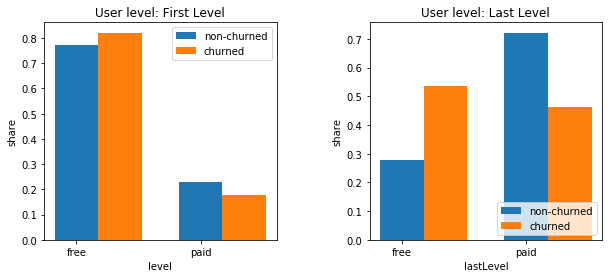

In [197]:
# Prepare data
df_user_firstLevel = calc_user_share(data.where(data.userRowId == 1).select('churn', 'userId', 'level'), 'level')
df_user_lastLevel = calc_user_share(data, 'lastLevel')

set_plot_size(10, 4);
plt.subplots_adjust(wspace=0.4)

# 1. First Level
plt.subplot(1, 2, 1)
plot_share(df_user_firstLevel, 'level', 'User level: First Level')

# 2. Last level
plt.subplot(1, 2, 2)
plot_share(df_user_lastLevel, 'lastLevel', 'User level: Last Level', 4)

### <span style="color:red">Significant user interaction features</span>
 - LastLevel

#### User-Time level: *Level*
Level category statistics per day

In [417]:
# convert date string to date type
def convert_to_date(date_str):
    return datetime.datetime.strptime(date_str, '%Y-%m-%d').date()

# get date string
def get_date_str(month, day):
    return '2018-' + str(month).zfill(2) + '-' + str(day).zfill(2)

# get date
def get_date(month, day):
    try:
        date_str = get_date_str(month, day)
        return datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
    except ValueError:
        return None   

# Return true if the date string is a valid date
def validate_date(month, day):
    try:
        date_str = get_date_str(month, day)
        datetime.datetime.strptime(date_str, '%Y-%m-%d')
        return True
    except ValueError:
        return False   
    
# get dates generator that returns (month, day) tuple between date1 and date2 
def get_dates_gen(date1, date2):
    for m in range(date1.month, date2.month+1):
        for d in range(1, 31+1):
            date = get_date(m, d)
            if date == None or date <= date1 or date >= date2:
                continue                      
            yield date    

# get user_time matrix row
def get_ut_row(userId, date, level):
    return {
        'userId': userId,
        'date': date,
        'level': level
    }

# get default (starting) date
def get_default_date():
    return datetime.datetime.strptime('2018-09-30', '%Y-%m-%d').date()


##### Add date components

In [277]:
# Add year, month, day columns
data = data.withColumn('date', to_date('tsDate'))
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free', date=datetime.date(2018, 11, 21))]

##### Extract unique user-time data with level information

In [282]:
# Extract user-time distinct rows with level value
extracted = data \
    .groupby('userId', 'date') \
    .agg(max('userRowId').alias('rowid')) \
    .select(col('userId').alias('uid'), 'date', 'rowid')
    
# Note: if a user has more than 1 different level per day, then we take the last level
user_time_rows = extracted \
    .join(data, (extracted.uid == data.userId) & (extracted.rowid == data.userRowId), how='inner') \
    .select(data.userId, extracted.date, data.level) \
    .sort('userId', 'date') \
    .collect()

##### Add missing user-time rows

In [290]:
# Observation period
data.agg(min('date'), max('date')).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



In [300]:
# Build user-time dimension matrix for the whole observation period from Oct 1, 2018 to Dec 3, 2018.
# Important: if in time t2 user has no user_time row, then it holds:
#
#    level(user, t2) = level(user, t1)
#

# user set
users = {row.userId for row in user_time_rows}

# user-time dimension matrix
ut_matrix = []

# current user-time level - fill it with default (None) values 
current_levels = dict()
for userId in users:
    current_levels[userId] = None

# convert user_time rows into pandas dataframe (for easier filtering)
utdf = pd.DataFrame(user_time_rows)
utdf.columns = ['userId', 'date', 'level']

# current dimension variables - defaults are set on Sept 30
last_userId, last_date = '-1', get_default_date()

# loop through the user-time rows sorted by userId, month, day
for row in user_time_rows:
    
    userId = row.userId
    
    # reset last date when user changes
    if userId != last_userId:
        last_date = get_default_date()
    
    # get current user level
    last_level = current_levels[userId]
    
    # add missing dimensions (up till current row date)
    #  level := last_level
    # Note: we skip None levels that represent missing logs before the first user log.
    if last_level != None:
        for date in get_dates_gen(last_date, row.date):
            ut_matrix.append(get_ut_row(userId, date, last_level))
        
    # add level for current row date
    ut_matrix.append(get_ut_row(userId, row.date, row.level))
       
    # handle history variables
    last_date = row.date       
    last_userId = userId
    current_levels[userId] = row.level
               

##### Calculate share of level per churn group, for each day in the observation period 

In [304]:
# Prepare churn data
churn_df = data.select('userId', 'churn').dropDuplicates().toPandas()

# Convert user_time matrix to pandas framework
ut_df = pd.DataFrame(ut_matrix)
ut_df = ut_df[['userId', 'date', 'level']]

# Add churn indicator
ut_df = ut_df.merge(churn_df, on='userId')

In [307]:
# Prepare agg totals per day and churn group
level_totals_df = ut_df \
    .groupby(['churn', 'date']) \
    .size() \
    .reset_index(name='count') \
    .rename(columns={'count': 'total'})

# create level share dataframe
level_share_df = ut_df \
    .groupby(['churn', 'date', 'level']) \
    .size() \
    .reset_index(name='count') \
    .merge(level_totals_df, on=['churn', 'date'])
    
# calc share
level_share_df['share'] = level_share_df['count']/level_share_df['total']

##### Plot total count of level category per day

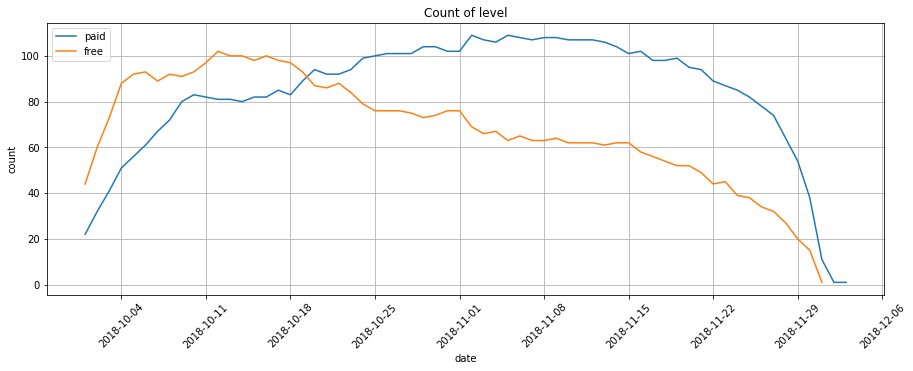

In [312]:
# Prepare agg totals per day and churn group
level_count_df = ut_df \
    .groupby(['level', 'date']) \
    .size() \
    .reset_index(name='count') \
    .sort_values(by=['date'])

# Plot
paid = level_count_df[level_count_df.level == 'paid']['count']
free = level_count_df[level_count_df.level == 'free']['count']
dates_paid = level_count_df[level_count_df.level == 'paid']['date']
dates_free = level_count_df[level_count_df.level == 'free']['date']

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

ax.plot(dates_paid, paid)
ax.plot(dates_free, free)

ax.set(xlabel='date', ylabel='count', title='Count of level')
ax.grid()
plt.legend(['paid', 'free'], loc=2)
plt.xticks(rotation = 45);
plt.show()

##### Plot share of a level category by churn group per day

In [309]:
# Share of a given level, per churn group
def plot_level_share(df, level):
    df_share = df[(df.level == level)]

    shares0 = df_share[df_share.churn == 0]['share']
    shares1 = df_share[df_share.churn == 1]['share']
    dates0 = df_share[df_share.churn == 0]['date']
    dates1 = df_share[df_share.churn == 1]['date']

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)

    # plot both lines
    ax.plot(dates0, shares0)
    ax.plot(dates1, shares1)

    ax.set(xlabel='date', ylabel='share', title="Share of level='" + level + "'")
    ax.grid()
    plt.legend(['non-churned', 'churned'], loc=2)
    plt.xticks(rotation = 45);
    plt.show()

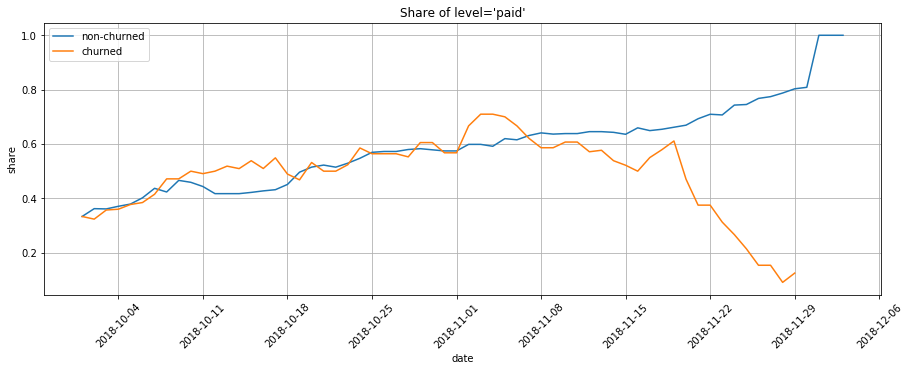

In [310]:
plot_level_share(level_share_df, 'paid')

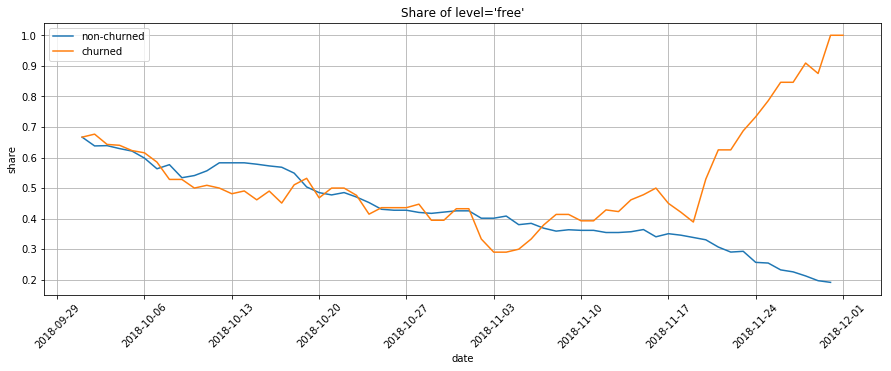

In [311]:
plot_level_share(level_share_df, 'free')

### Song level

#### Common Functions

In [58]:
# Map churn values to churn names
def map_churn(churn):
    if churn == 0:
        return 'non-churned'
    else:
        return 'churned'
    
def map_churn_df(df):
    df['churnName'] = df['churn'].apply(map_churn)
    return df

# Convert average values into ratio between both churn groups
def calc_ratio(df, column, feature=None):
    if feature != None:  
        df = df.merge(df.groupby(feature).sum().reset_index(), on=feature, suffixes=['', '_sum'])
        df['ratio'] = df[column]/df[column + '_sum']
        df = df[['churn', feature, column, 'ratio']]
        return df.sort_values(by=[feature, 'churn'])
    else:
        df['ratio'] = df[column]/df.sum()[column]
        df = df[['churn', column, 'ratio']]
        return df.sort_values(by='churn')   
    
def plot_ratio(df, title):
    set_plot_size(4, 4)
    df = song_avg_df.copy().sort_values(by='ratio', ascending=False)
    labels = df['churnName']
    plt.xticks(range(2), labels)
    plt.xticks(df.churn, labels)
    plt.xlabel('')
    plt.ylabel('ratio')
    ratio_bars = plt.bar(range(2), df['ratio'], width=0.7);
    ratio_bars[1].set_color('orange')
    ax = plt.gca()
    ax.set_title(title);
    plt.show()
    

#### Song level: *Average songs per user, per churn group*
We calculate an average song count per user, per churn group 

In [852]:
song_avg_df = data \
    .where(data.page == 'NextSong') \
    .groupby('churn', 'userId') \
    .count() \
    .groupby('churn') \
    .agg(avg('count').alias('avg')) \
    .toPandas()[['churn', 'avg']]

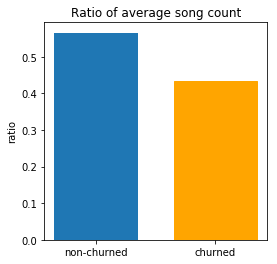

In [1038]:
plot_ratio(song_avg_df, 'Ratio of average song count')

### <span style="color:red">Significant user interaction features</span> (DEPR: we use LogCount instead)
 - Average Song Count

#### Song-Time level: *Count per day*

In [364]:
# Extract data
song_count_df = data \
    .where(data.page == 'NextSong') \
    .groupby('churn', 'date') \
    .count() \
    .sort('date') \
    .toPandas()

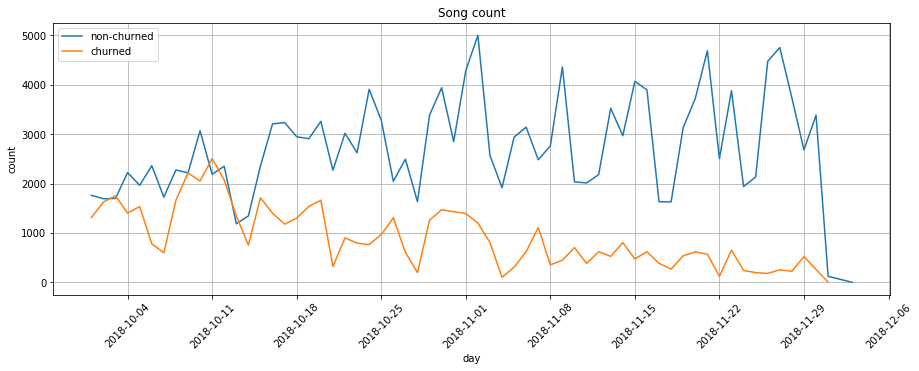

In [568]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

df0 = song_count_df[song_count_df.churn == 0]
df1 = song_count_df[song_count_df.churn == 1]
ax.plot(df0['date'], df0['count'])
ax.plot(df1['date'], df1['count'])

ax.set(xlabel='day', ylabel='count', title='Song count')
ax.grid()
plt.legend(['non-churned', 'churned'], loc=2)
plt.xticks(rotation = 45);
plt.show()

#### Song-Time level: *Average count per user (by date)*

In [473]:
# Extract data
song_avg_df = data \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', 'date') \
    .count() \
    .groupby('churn', 'date') \
    .avg() \
    .select('churn', 'date', col('avg(count)').alias('avg')) \
    .sort('date') \
    .toPandas()

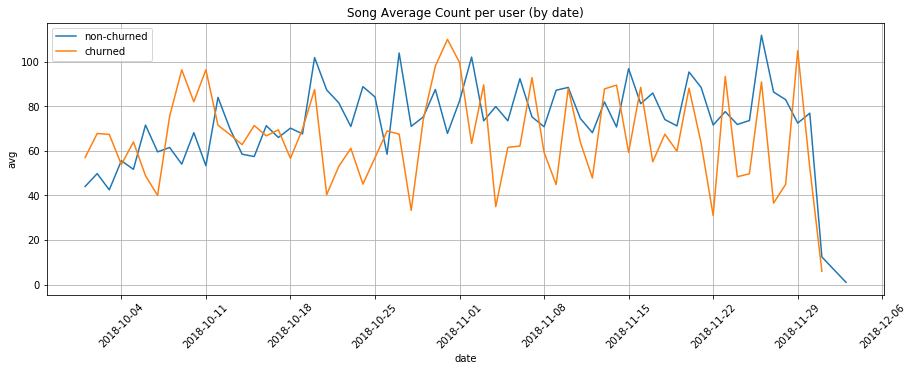

In [569]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

df0 = song_avg_df[song_avg_df.churn == 0]
df1 = song_avg_df[song_avg_df.churn == 1]
ax.plot(df0['date'], df0['avg'])
ax.plot(df1['date'], df1['avg'])

ax.set(xlabel='date', ylabel='avg', title='Song Average Count per user (by date)')
ax.grid()
plt.legend(['non-churned', 'churned'], loc=2)
plt.xticks(rotation = 45);
plt.show()

In [ ]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

df0 = song_avg_df[song_avg_df.churn == 0]
df1 = song_avg_df[song_avg_df.churn == 1]
ax.plot(df0['date'], df0['avg'])
ax.plot(df1['date'], df1['avg'])

ax.set(xlabel='date', ylabel='avg', title='Song Average Count per user (by date)')
ax.grid()
plt.legend(['non-churned', 'churned'], loc=2)
plt.xticks(rotation = 45);
plt.show()

#### Song-Time level: *Average count per user (by week of year)*

In [573]:
# Extract data
song_avg_week_df = data \
    .withColumn('weekOfYear', date_format(col('tsDate'), "w")) \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', 'weekOfYear') \
    .count() \
    .groupby('churn', 'weekOfYear') \
    .avg() \
    .select('churn', 'weekOfYear', col('avg(count)').alias('avg')) \
    .sort('weekOfYear') \
    .toPandas()

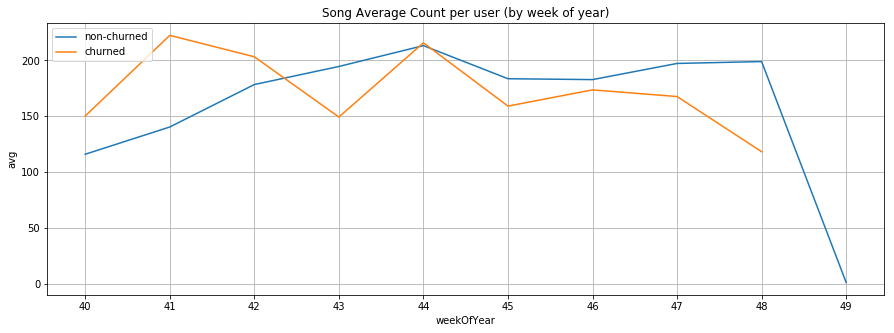

In [575]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

df0 = song_avg_week_df[song_avg_week_df.churn == 0]
df1 = song_avg_week_df[song_avg_week_df.churn == 1]
ax.plot(df0['weekOfYear'], df0['avg'])
ax.plot(df1['weekOfYear'], df1['avg'])

ax.set(xlabel='weekOfYear', ylabel='avg', title='Song Average Count per user (by week of year)')
ax.grid()
plt.legend(['non-churned', 'churned'], loc=2)
plt.show()

#### Song-Time level: *Average count per user* (by day of week)

In [484]:
# Extract data
song_avg_dayOfWeek_df = data \
    .withColumn('dayOfWeek', date_format(col('date'), 'E')) \
    .withColumn('dayOfWeekNum', date_format(col('date'), "u")) \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', 'dayOfWeekNum', 'dayOfWeek') \
    .count() \
    .groupby('churn', 'dayOfWeekNum', 'dayOfWeek') \
    .avg() \
    .select('churn', 'dayOfWeekNum', 'dayOfWeek', col('avg(count)').alias('avg')) \
    .sort('dayOfWeekNum') \
    .toPandas()

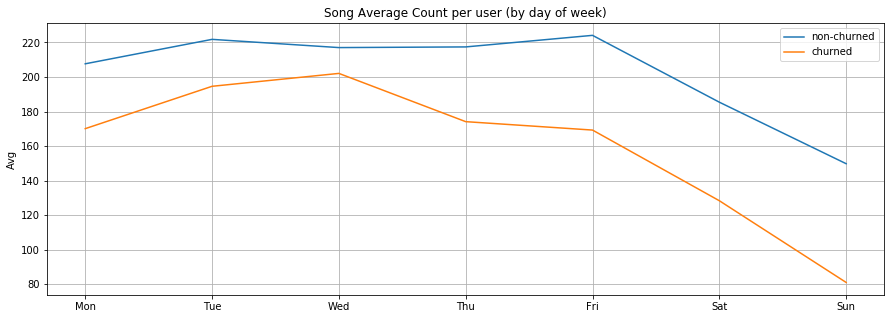

In [599]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

df0 = song_avg_dayOfWeek_df[song_avg_dayOfWeek_df.churn == 0]
df1 = song_avg_dayOfWeek_df[song_avg_dayOfWeek_df.churn == 1]
ax.plot(df0['dayOfWeekNum'], df0['avg'])
ax.plot(df1['dayOfWeekNum'], df1['avg'])

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.set_xticklabels(labels)
ax.grid()
ax.set_ylabel('Avg')
ax.set_title('Song Average Count per user (by day of week)')
plt.legend(['non-churned', 'churned'], loc=1)
plt.show()

#### Song-Time level: *Average count per user* (by hour of day)

In [561]:
# Extract data
song_avg_hour_df = data \
    .withColumn('hour', hour(col('tsDate'))) \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', 'hour') \
    .count() \
    .groupby('churn', 'hour') \
    .avg() \
    .select('churn', 'hour', col('avg(count)').alias('avg')) \
    .sort('hour') \
    .toPandas()

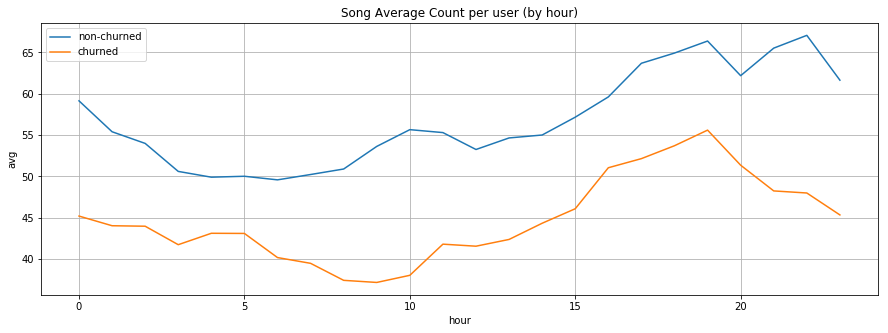

In [565]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

df0 = song_avg_hour_df[song_avg_hour_df.churn == 0]
df1 = song_avg_hour_df[song_avg_hour_df.churn == 1]
ax.plot(df0['hour'], df0['avg'])
ax.plot(df1['hour'], df1['avg'])

ax.set(xlabel='hour', ylabel='avg', title='Song Average Count per user (by hour)')
ax.grid()
plt.legend(['non-churned', 'churned'], loc=2)
plt.show()

### Session level

#### Session level: *Average sessions per user, average session duration per user, for each churn group*

In [1039]:
session_stats_df = data \
    .groupby('churn', 'userId', 'sessionId') \
    .agg(count('sessionId').alias('logCount'), ((max('ts') - min('ts'))/60000).alias('duration')) \
    .groupby('churn', 'userId') \
    .agg(count('userId').alias('sessionCount'), \
         avg('duration').alias('duration')) \
    .groupby('churn') \
    .agg(avg('sessionCount').alias('avgSessionCount'), \
         avg('duration').alias('avgDuration')) \
    .sort('churn') \
    .toPandas()

In [1040]:
session_stats_df

,churn,avgSessionCount,avgDuration
0,0,14.601266,300.087962
1,1,12.970149,260.051468


In [1042]:
calc_ratio(session_stats_df, 'avgSessionCount')

,churn,avgSessionCount,ratio
0,0,14.601266,0.52958
1,1,12.970149,0.47042


In [1043]:
calc_ratio(session_stats_df, 'avgDuration')

,churn,avgDuration,ratio
0,0,300.087962,0.535738
1,1,260.051468,0.464262


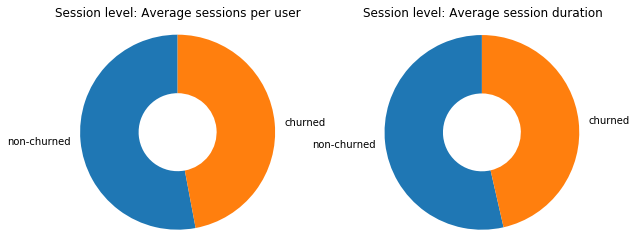

In [1044]:
set_plot_size(10, 4); 

# 1. Sesions per user
plt.subplot(1, 2, 1)
plt.pie(session_stats_df['avgSessionCount'], labels = ['non-churned', 'churned'], startangle = 90, \
        counterclock = True, wedgeprops = {'width' : 0.6});
plt.axis('square')
ax = plt.gca()
ax.set_title('Session level: Average sessions per user');  
    
# 2. Session duration
plt.subplot(1, 2, 2)
plt.pie(session_stats_df['avgDuration'], labels = ['non-churned', 'churned'], startangle = 90, \
        counterclock = True, wedgeprops = {'width' : 0.6});
plt.axis('square')
ax = plt.gca()
ax.set_title('Session level: Average session duration');

plt.show()

### <span style="color:red">Significant user interaction features</span>
 - Average session duration

#### Session level: *Average logs per hour*

In [932]:
data.where((data.userId == 124) & (data.sessionId == 628)).select('tsDate', 'churn', 'userId', 'sessionId', 'page') \
    .show(100)

+-------------------+-----+------+---------+--------+
|             tsDate|churn|userId|sessionId|    page|
+-------------------+-----+------+---------+--------+
|2018-10-10 02:48:01|    0|   124|      628|    Home|
|2018-10-10 02:48:04|    0|   124|      628|NextSong|
|2018-10-10 02:51:01|    0|   124|      628|    Home|
|2018-10-10 02:51:39|    0|   124|      628|NextSong|
|2018-10-10 02:54:52|    0|   124|      628|NextSong|
|2018-10-10 02:54:53|    0|   124|      628|  Logout|
|2018-10-10 02:57:46|    0|   124|      628|    Home|
+-------------------+-----+------+---------+--------+



In [940]:
session_logs_per_hour_df = data \
    .groupby('churn', 'userId', 'sessionId') \
    .agg(count('sessionId').alias('logCount'), \
        ((max('ts') - min('ts'))/1000/60/60).alias('hours')) \
    .groupby('churn', 'userId') \
    .agg(Fsum('hours').alias('hours'), \
        Fsum('logCount').alias('logCount')) \
    .groupby('churn') \
    .agg(avg(col('logCount')/col('hours')).alias('avgLogCountPerHour')) \
    .sort('churn') \
    .toPandas()

In [941]:
session_logs_per_hour_df

,churn,avgLogCountPerHour
0,0,18.168568
1,1,18.951477


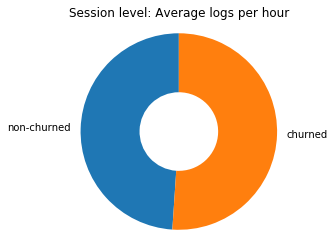

In [942]:
plt.pie(session_logs_per_hour_df['avgLogCountPerHour'], labels = ['non-churned', 'churned'], startangle = 90, \
        counterclock = True, wedgeprops = {'width' : 0.6});
plt.axis('square')
ax = plt.gca()
ax.set_title('Session level: Average logs per hour');

In [947]:
session_logs_per_hour_cancelled_df

,cancelled,avgLogCountPerHour
0,0,18.162460
1,1,19.197636


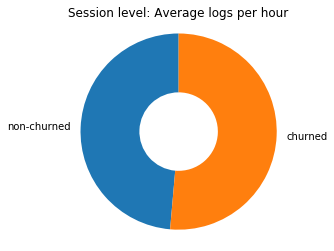

In [948]:
plt.pie(session_logs_per_hour_cancelled_df['avgLogCountPerHour'], labels = ['non-churned', 'churned'], startangle = 90, \
        counterclock = True, wedgeprops = {'width' : 0.6});
plt.axis('square')
ax = plt.gca()
ax.set_title('Session level: Average logs per hour');

In [934]:
# Churn user example with 108 logs in 3 sessions until cancelling the subscription
data.where(data.userId == 32).select('tsDate', 'sessionId', 'userId', 'page', 'song', 'length').show(150)

+-------------------+---------+------+--------------------+--------------------+---------+
|             tsDate|sessionId|userId|                page|                song|   length|
+-------------------+---------+------+--------------------+--------------------+---------+
|2018-10-03 17:01:37|      218|    32|            NextSong|Beyond The Beyond...|237.53098|
|2018-10-03 17:05:34|      218|    32|            NextSong|       Paradise City|406.17751|
|2018-10-03 17:12:20|      218|    32|            NextSong|           Alejandro|274.18077|
|2018-10-03 17:12:45|      218|    32|         Roll Advert|                null|     null|
|2018-10-03 17:16:54|      218|    32|            NextSong|        Luv U Better| 242.6771|
|2018-10-03 17:16:55|      218|    32|           Thumbs Up|                null|     null|
|2018-10-03 17:20:56|      218|    32|            NextSong|My Life Would Suc...|211.56526|
|2018-10-03 17:21:08|      218|    32|     Add to Playlist|                null|     null|

In [930]:
session_stats_hour_df = data \
    .groupby('churn', 'userId', 'sessionId') \
    .agg(count('sessionId').alias('logCount'), \
         ((max('ts') - min('ts'))/1000/60/60).alias('hours')) \
    .groupby('churn', 'userId') \
    .agg(count('userId').alias('sessionCount'), \
         Fsum('hours').alias('hours'), \
         Fsum('logCount').alias('logCount')) \
    .groupby('churn') \
    .agg(avg('sessionCount').alias('avgSessionCount'), \
         (avg('logCount')/col('hours')).alias('avgLogCount')) \
    .sort('churn') \
    .toPandas()

AnalysisException: expression '`hours`' is neither present in the group by, nor is it an aggregate function. Add to group by or wrap in first() (or first_value) if you don't care which value you get.;;
Aggregate [churn#4788], [churn#4788, avg(sessionCount#15928L) AS avgSessionCount#15944, (avg(logCount#15932L) / hours#15930) AS avgLogCount#15946]
+- Aggregate [churn#4788, userId#24], [churn#4788, userId#24, count(userId#24) AS sessionCount#15928L, sum(hours#15916) AS hours#15930, sum(logCount#15913L) AS logCount#15932L]
   +- Aggregate [churn#4788, userId#24, sessionId#19L], [churn#4788, userId#24, sessionId#19L, count(sessionId#19L) AS logCount#15913L, (((cast((max(ts#22L) - min(ts#22L)) as double) / cast(1000 as double)) / cast(60 as double)) / cast(60 as double)) AS hours#15916]
      +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740, to_date('tsDate, None) AS date#8962]
         +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740]
            +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740, date#8355]
               +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740, tsDay#8328, date#8355]
                  +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740, tsMonth#8301, ... 2 more fields]
                     +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740, tsYear#8274, ... 3 more fields]
                        +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740, tsYear#8274, ... 2 more fields]
                           +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740, tsYear#8274, ... 2 more fields]
                              +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740, year(cast(tsDate#1165 as date)) AS tsYear#8274, ... 2 more fields]
                                 +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740, tsYear#7690, ... 2 more fields]
                                    +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740, tsYear#7690, month(cast(tsDate#1165 as date)) AS tsMonth#7715]
                                       +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740, year(cast(tsDate#1165 as date)) AS tsYear#7690]
                                          +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, <lambda>(userId#24, churn#4593) AS churn#4788, userRowId#4641, userRowDescId#4664, lastLevel#4740]
                                             +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641, userRowDescId#4664, <lambda>(userId#24) AS lastLevel#4740]
                                                +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641, userRowDescId#4664]
                                                   +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641, userRowDescId#4664, userRowDescId#4664]
                                                      +- Window [row_number() windowspecdefinition(userId#24, ts#22L DESC NULLS LAST, itemInSession#11L DESC NULLS LAST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS userRowDescId#4664], [userId#24], [ts#22L DESC NULLS LAST, itemInSession#11L DESC NULLS LAST]
                                                         +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641]
                                                            +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641]
                                                               +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593, userRowId#4641, userRowId#4641]
                                                                  +- Window [row_number() windowspecdefinition(userId#24, ts#22L ASC NULLS FIRST, itemInSession#11L ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS userRowId#4641], [userId#24], [ts#22L ASC NULLS FIRST, itemInSession#11L ASC NULLS FIRST]
                                                                     +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, churn#4593]
                                                                        +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, <lambda>(userId#24) AS churn#4593]
                                                                           +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220, <lambda>(userId#24) AS churn#4478]
                                                                              +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, state#1220]
                                                                                 +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, city#1200, split(location#15, ,, -1)[1] AS state#1220]
                                                                                    +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, tsDate#1165, split(location#15, ,, -1)[0] AS city#1200]
                                                                                       +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, regDate#1147, cast((cast(ts#22L as double) / cast(1000.0 as double)) as timestamp) AS tsDate#1165]
                                                                                          +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24, cast((cast(registration#18L as double) / cast(1000.0 as double)) as timestamp) AS regDate#1147]
                                                                                             +- Project [artist#7, auth#8, gender#10, itemInSession#11L, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24]
                                                                                                +- Project [artist#7, auth#8, gender#10, itemInSession#11L, lastName#12, length#13, level#14, location#15, method#16, page#17, registration#18L, sessionId#19L, song#20, status#21L, ts#22L, userAgent#23, userId#24]
                                                                                                   +- Filter NOT (isnull(userId#24) OR (userId#24 = ))
                                                                                                      +- Relation[artist#7,auth#8,firstName#9,gender#10,itemInSession#11L,lastName#12,length#13,level#14,location#15,method#16,page#17,registration#18L,sessionId#19L,song#20,status#21L,ts#22L,userAgent#23,userId#24] json


### Page level
Note: The *Cancel*, *Cancellation Confirmation*, and *Submit Downgrade* events are excluded from the page level statistics since **they form part of the label definition**. While the first two features are exclusively "churned", the *Submit Downgrade* event does not exclusively defines the churned group. However, when there is a single *Submit Downgrade* event per user (without upgrading), then this event also denotes exclusively a churned group.  

In [35]:
page_data = data.where(~data.page.isin(['Cancel', 'Cancellation Confirmation', 'Submit Downgrade']))

#### Common Functions

In [62]:
def plot_ratio_feature(df, feature, title, loc=1):
    # Split data by churn
    df0 = df[df.churn == 0].sort_values([feature, 'churn']).copy()
    df1 = df[df.churn == 1].sort_values([feature, 'churn']).copy()

    label_names = ['non-churned', 'churned']

    # Plot
    set_plot_size(15, 6);
    width = 0.35
    labels = df0['page'].sort_values()
    plt.xticks(range(len(labels)), labels)
    plt.xlabel(feature)
    plt.ylabel('ratio')
    plt.bar(np.arange(len(df0)), df0['ratio'], width=width)
    plt.bar(np.arange(len(df1))+width, df1['ratio'], width=width)
    plt.xticks(rotation = 90);
    ax = plt.gca()
    ax.set_title(title);
    plt.legend(label_names, loc=loc)
    
    # mark middle 0.5 line
    plt.plot((-1, 16), (0.50, 0.50), color='black', linestyle='-', linewidth=1)
    plt.plot((-1, 16), (0.55, 0.55), color='red', linestyle=':', linewidth=2)
    plt.plot((-1, 16), (0.45, 0.45), color='red', linestyle=':', linewidth=2)
    
    plt.show()

#### Page level: *Count*
We calculate ratio of a **page count** where data is aggregated by *churn group*. 

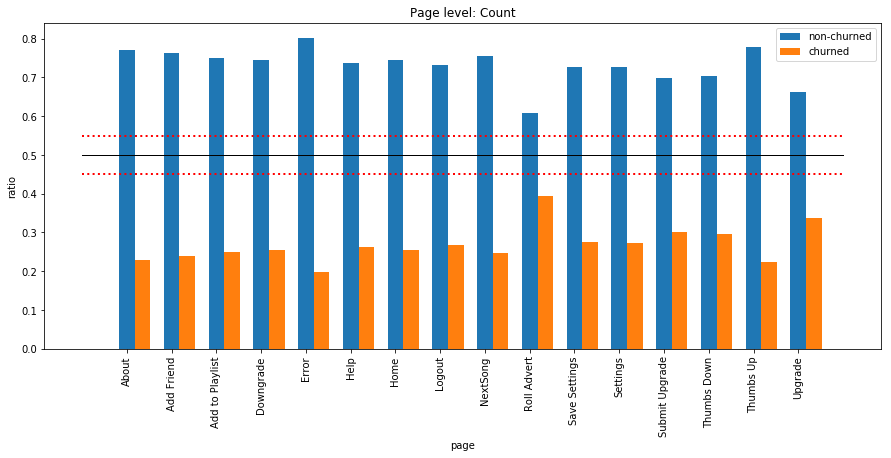

In [1014]:
page_count_df = page_data \
    .select('churn', 'page') \
    .groupby('churn', 'page') \
    .count() \
    .toPandas()
    
page_count_df = calc_ratio(page_count_df, 'count', 'page') 

plot_ratio_feature(page_count_df, 'page', 'Page level: Count')

#### Page level: *Average count*
We calculate ratio of an **average page count** where data is aggregated by *churn group*, *user*.

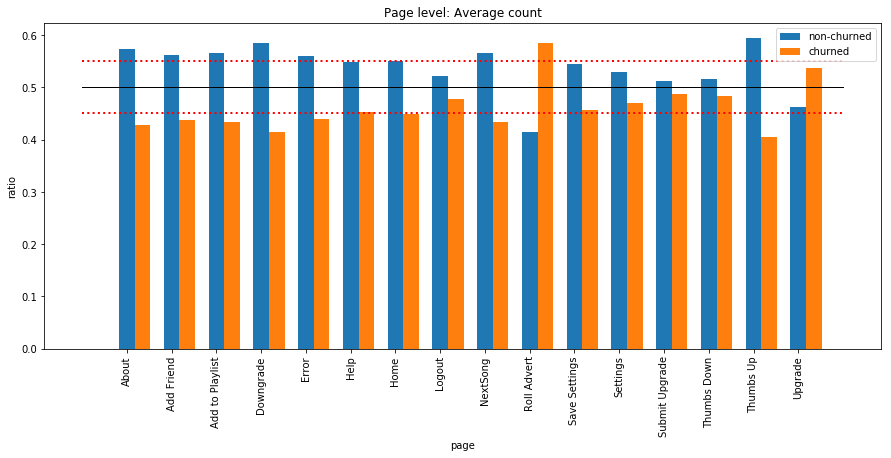

In [1015]:
page_count_avg_df = page_data \
    .groupby('churn', 'page', 'userId') \
    .count() \
    .groupby('churn', 'page') \
    .avg() \
    .select('churn', 'page', col('avg(count)').alias('avg')) \
    .toPandas()
    
page_count_avg_df = calc_ratio(page_count_avg_df, 'avg', 'page') 

plot_ratio_feature(page_count_avg_df, 'page', 'Page level: Average count')

### <span style="color:red">Significant user interaction features</span>
 - Roll Advert (+)
 - Upgrade (+)

In [974]:
# Check Roll Advert (OK)
data.where(data.page == 'Roll Advert') \
    .groupby('churn', 'userId') \
    .count() \
    .groupby('churn') \
    .avg() \
    .show()

+-----+----------+------------------+
|churn|avg(churn)|        avg(count)|
+-----+----------+------------------+
|    1|       1.0| 23.76923076923077|
|    0|       0.0|16.816901408450704|
+-----+----------+------------------+



#### Page level: *Average count per hour*
We calculate ratio of an **average page count per hour** where data is aggregated by *churn group*, *user*, *session*, *hour*.

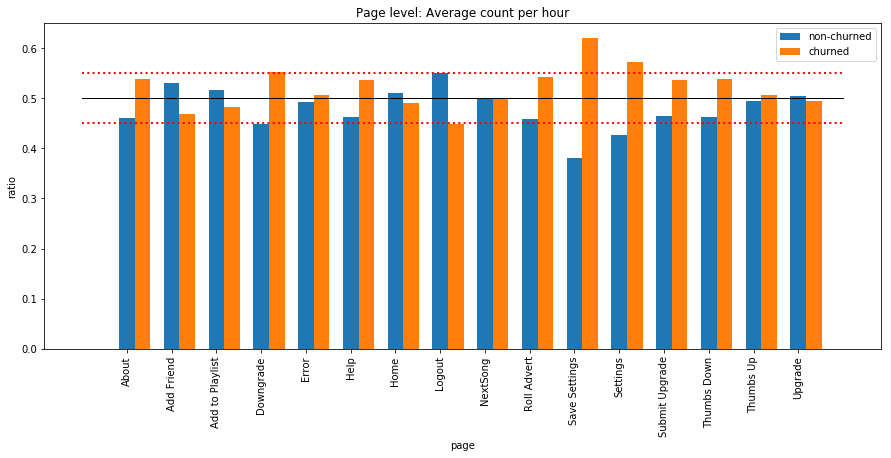

In [1016]:
page_hour = page_data \
    .join(page_data \
        .groupby('userId', 'sessionId') \
        .agg(((max('ts') - min('ts'))/1000/3600).alias('duration')) \
        .select('userId', 'sessionId', round(col('duration'), 1).alias('sessionDuration')), \
            on = ['userId', 'sessionId'], how = 'inner') \
    .select('churn', 'userId', 'sessionId', 'sessionDuration', 'page')

page_count_avg_hour_df = page_hour \
    .groupby('page', 'churn', 'userId', 'sessionId', 'sessionDuration') \
    .agg((count('page')/col('sessionDuration')).alias('avg')) \
    .groupby('page', 'churn', 'userId') \
    .agg(avg('avg').alias('avg')) \
    .groupby('page', 'churn') \
    .agg(avg('avg').alias('avg')) \
    .toPandas() 

page_count_avg_hour_df = calc_ratio(page_count_avg_hour_df, 'avg', 'page') 

plot_ratio_feature(page_count_avg_hour_df, 'page', 'Page level: Average count per hour')

In [1057]:
# Get sum of duration in hours for all user page interactions

user_hours = page_data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('hours')) \
    .groupby('userId') \
    .agg(Fsum('hours').alias('hours'))
    

In [1054]:
user_hours.count()

225

In [1053]:
data.where(data.userId == 300017).groupby('sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('hours')) \
    .groupby() \
    .sum() \
    .show()

+--------------+-----------------+
|sum(sessionId)|       sum(hours)|
+--------------+-----------------+
|         16597|244.9902777777778|
+--------------+-----------------+



In [1059]:
page_data.where(page_data.userId == 300017) \
    .join(user_hours, 'userId', 'inner') \
    .groupby('page', 'churn', 'userId', 'hours') \
    .agg((count('page')/col('hours')).alias('countPerHours')) \
    .show()

+---------------+-----+------+------------------+--------------------+
|           page|churn|userId|             hours|       countPerHours|
+---------------+-----+------+------------------+--------------------+
|       NextSong|    0|300017|244.99027777777778|  14.825078092668077|
|      Thumbs Up|    0|300017|244.99027777777778|  1.2367837725986859|
|         Logout|    0|300017|244.99027777777778| 0.16735357979058127|
|           Home|    0|300017|244.99027777777778|  0.6163509889848237|
|     Add Friend|    0|300017|244.99027777777778| 0.25715306162942975|
|Add to Playlist|    0|300017|244.99027777777778|  0.4612427930813581|
|           Help|    0|300017|244.99027777777778| 0.11020845498404132|
|          About|    0|300017|244.99027777777778|0.012245383887115702|
|      Downgrade|    0|300017|244.99027777777778| 0.10204486572596418|
|    Thumbs Down|    0|300017|244.99027777777778| 0.11429024961307989|
|       Settings|    0|300017|244.99027777777778| 0.09388127646788705|
|  Sav

#### Better Avg count page per hour, per churn group

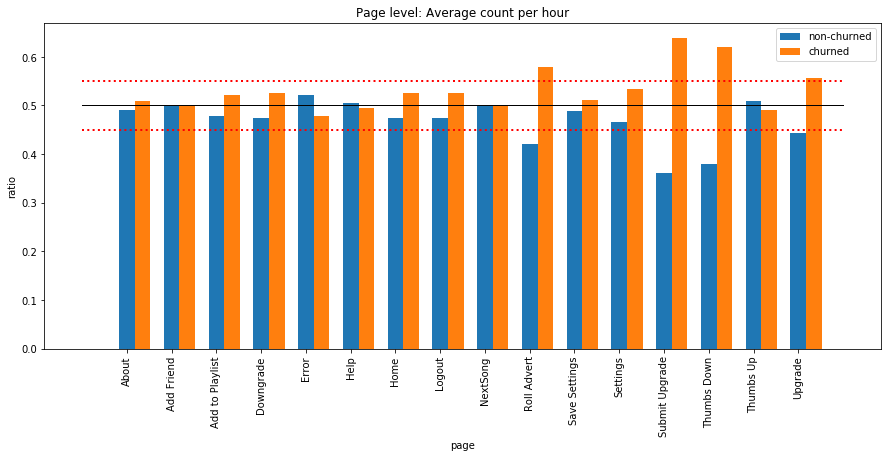

In [65]:
user_hours = page_data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('hours')) \
    .groupby('userId') \
    .agg(Fsum('hours').alias('hours'))
    
page_count_per_hour_df = page_data \
    .join(user_hours, 'userId', 'inner') \
    .groupby('page', 'churn', 'userId', 'hours') \
    .agg((count('page')/col('hours')).alias('countPerHour')) \
    .groupby('page', 'churn') \
    .agg(avg('countPerHour').alias('avgPerHour')) \
    .toPandas() 

page_count_per_hour_df = calc_ratio(page_count_per_hour_df, 'avgPerHour', 'page') 

plot_ratio_feature(page_count_per_hour_df, 'page', 'Page level: Average count per hour')

In [1048]:
page_count_avg_hour_df[page_count_avg_hour_df.page == 'Save Settings']

,churn,page,avg,ratio
21,0,Save Settings,0.335581,0.379814
20,1,Save Settings,0.547958,0.620186


### <span style="color:red">Significant user interaction features</span>
 - About (+)
 - Add Friend (-)
 - Downgrade (+)
 - Help (+)
 - Logout (-)
 - Roll Advert (+)
 - Save Settings (+)
 - Settings (+)
 - Submit Upgrade (+)
 - Thumbs Down (+)

#### Page level: *Share of page interactions of total user interactions*
(Note: *Cancel* and *Cancellation Confirmation* interactions are excluded)

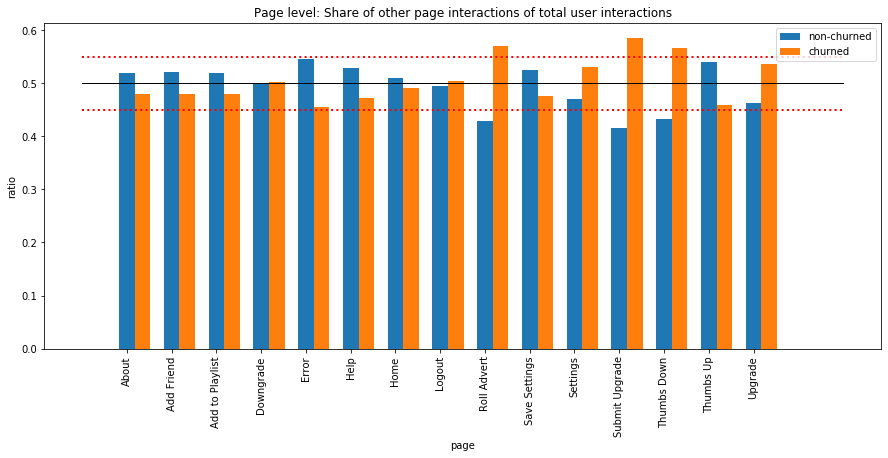

In [64]:
other_page_data = page_data.where(page_data.page != 'NextSong')

other_page_user_share_df = other_page_data \
    .groupby('churn', 'userId', 'page') \
    .count() \
    .join(user_data, on = ['userId'], how = 'inner') \
    .select(page_data.churn, page_data.page, (col('count')/col('total')).alias('share')) \
    .groupby('churn', 'page') \
    .agg(avg('share').alias('share')) \
    .toPandas()

other_page_user_share_df = calc_ratio(other_page_user_share_df, 'share', 'page')

plot_ratio_feature(other_page_user_share_df, 'page', 'Page level: Share of other page interactions of total user interactions')

### <span style="color:red">Significant user interaction features</span>
 - Roll Advert (+)
 - Settings (+)
 - Submit Upgrade (+)
 - Thumbs Down (+)
 - Upgrade (+)

### Song level

#### Song level: *Average Length*
We calculate an **average length of song listening activity** where data is aggregated by *churn group*.

In [924]:
data \
    .where(data.page == 'NextSong') \
    .select('churn', 'length') \
    .groupby('churn') \
    .agg(avg('length').alias('avgLength')) \
    .show()

+-----+-----------------+
|churn|        avgLength|
+-----+-----------------+
|    1|249.0748660669342|
|    0|249.1309587536258|
+-----+-----------------+



#### Song level: *Average Length per session*
We calculate an **average length of song listening activity per session** where data is aggregated by *churn group*, *user*, *session*.

In [923]:
data \
    .where(data.page == 'NextSong') \
    .select('churn', 'userId', 'sessionId', 'length') \
    .groupby('churn', 'userId', 'sessionId') \
    .agg(avg('length').alias('avgLength')) \
    .groupby('churn', 'userId') \
    .agg(avg('avgLength').alias('avgLength')) \
    .groupby('churn') \
    .agg(avg('avgLength').alias('avg')) \
    .show()

+-----+------------------+
|churn|               avg|
+-----+------------------+
|    1|247.87298151386202|
|    0|249.81362008659525|
+-----+------------------+



#### Song level: *song length*

In [1063]:
data \
    .where(data.page == 'NextSong') \
    .select('churn', 'userId', 'sessionId', 'length') \
    .groupby('churn', 'userId', 'sessionId') \
    .agg(Fsum('length').alias('length')) \
    .groupby('churn', 'userId') \
    .agg(Fsum('length').alias('length')) \
    .groupby('churn') \
    .agg(avg('length').alias('lengthTotal')) \
    .show()

+-----+------------------+
|churn|       lengthTotal|
+-----+------------------+
|    1|208274.91599104478|
|    0| 271336.7264253165|
+-----+------------------+



In [1072]:
user_duration = page_data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000.0).alias('duration')) \
    .groupby('userId') \
    .agg(Fsum('duration').alias('duration'))
    
song_time_share = data \
    .join(user_duration, 'userId', 'inner') \
    .where(data.page == 'NextSong') \
    .select('userId', 'length', 'duration') \
    .groupby('userId', 'duration') \
    .agg((Fsum('length')/col('duration')).alias('songshare'))
    
song_time_share = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'length') \
    .groupby('userId') \
    .agg(Fsum('length').alias('songlen'))
    .select('userId', 'songlen')
    

In [1076]:
    
song_time_share = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'length') \
    .groupby('userId') \
    .agg(Fsum('length').alias('songlen')) \
    .select('userId', 'songlen') \
    .join(user_duration, 'userId', 'inner') \
    .select('userId', 'songlen', 'duration', (col('songlen')/col('duration')).alias('songshare'))
    

In [1078]:
data \
    .where(data.page == 'NextSong') \
    .select('churn', 'userId', 'length') \
    .groupby('churn', 'userId') \
    .agg(Fsum('length').alias('songlen')) \
    .select('churn', 'userId', 'songlen') \
    .join(user_duration, 'userId', 'inner') \
    .select('churn', 'userId', 'songlen', 'duration', (col('songlen')/col('duration')).alias('songshare')) \
    .groupby('churn') \
    .agg(avg('songshare').alias('avgsongshare')) \
    .show()
    

+-----+------------------+
|churn|      avgsongshare|
+-----+------------------+
|    1|1.0033254439343913|
|    0|1.0019478977452783|
+-----+------------------+



In [1077]:
song_time_share.show()

+------+------------------+---------+------------------+
|userId|           songlen| duration|         songshare|
+------+------------------+---------+------------------+
|100010|       66940.89735|  64883.0|1.0317170499206263|
|200002| 94008.87593999993|  95904.0| 0.980239363738738|
|   125|2089.1131000000005|   1773.0| 1.178292780597857|
|   124|1012312.0927900008|1007450.0|1.0048261380614432|
|    51| 523275.8428000004| 523271.0| 1.000009254860293|
|     7|        38034.0871|  36809.0|1.0332822706403324|
|    15| 477307.6058100001| 475455.0|1.0038964903303154|
|    54| 711344.9195399994| 715451.0|0.9942608502049748|
|   155|198779.29190000004| 197486.0|1.0065487776348705|
|100014|       67703.47208|  66525.0|1.0177147249906051|
|   132| 483118.9038399998| 478993.0|1.0086137038328322|
|   154|20660.023910000004|  19923.0|1.0369936209406216|
|   101| 447464.0146699989| 490320.0|0.9125958856868961|
|    11|159669.96304000003| 154922.0|1.0306474421967184|
|   138|512449.88275999983| 507

#### Std of session length

In [69]:
session_length = data \
    .groupby('churn', 'userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000.0).alias('duration')) \
    .groupby('churn', 'userId') \
    .agg(Fsum('duration').alias('duration'))

In [68]:
session_length.where(session_length.churn == 0).select('duration').describe().show()

+-------+------------------+
|summary|          duration|
+-------+------------------+
|  count|               158|
|   mean|272351.34810126584|
| stddev|291481.29645592987|
|    min|             420.0|
|    max|         1968410.0|
+-------+------------------+



In [70]:
session_length.where(session_length.churn == 1).select('duration').describe().show()

+-------+------------------+
|summary|          duration|
+-------+------------------+
|  count|                67|
|   mean|209623.59701492538|
| stddev|231201.74489655983|
|    min|            1774.0|
|    max|         1469115.0|
+-------+------------------+



### Study of 'churned' session

In [72]:
data.where(data.userId == 100017).select('tsDate', 'sessionId', 'page', 'level').show(100)

+-------------------+---------+--------------------+-----+
|             tsDate|sessionId|                page|level|
+-------------------+---------+--------------------+-----+
|2018-10-20 17:54:51|       17|            NextSong| free|
|2018-10-20 17:57:27|       17|            NextSong| free|
|2018-10-20 18:01:06|       17|            NextSong| free|
|2018-10-20 18:04:51|       17|            NextSong| free|
|2018-10-20 18:08:50|       17|            NextSong| free|
|2018-10-20 18:08:51|       17|         Thumbs Down| free|
|2018-10-20 18:11:21|       17|            NextSong| free|
|2018-10-20 18:15:39|       17|            NextSong| free|
|2018-10-20 18:20:02|       17|            NextSong| free|
|2018-10-20 18:20:20|       17|         Roll Advert| free|
|2018-10-20 18:23:54|       17|            NextSong| free|
|2018-10-20 18:28:31|       17|            NextSong| free|
|2018-10-20 18:28:52|       17|         Roll Advert| free|
|2018-10-20 18:31:40|       17|            NextSong| fre

In [79]:
data.where((data.page == 'Cancellation Confirmation') & (data.lastLevel == 'free')).select('userId', 'sessionId').show()

+------+---------+
|userId|sessionId|
+------+---------+
|   125|      174|
|   143|      843|
|100011|       40|
|100001|       53|
|100024|       42|
|100006|        6|
|100019|       71|
|100003|       86|
|100005|      115|
|100017|       17|
|100025|      129|
|100009|      145|
|100012|      156|
|100022|      191|
|100021|      172|
|200001|      136|
|200011|      267|
|200018|      268|
|200015|      270|
|200016|      347|
+------+---------+
only showing top 20 rows



In [ ]:
# 71, 3, 

In [87]:
data.where((data.userId == 100005) & (data.sessionId == 115)) \
    .select('tsDate', 'sessionId', 'page', 'status', 'level') \
    .show(200)

+-------------------+---------+--------------------+------+-----+
|             tsDate|sessionId|                page|status|level|
+-------------------+---------+--------------------+------+-----+
|2018-10-19 16:27:52|      115|                Home|   200| free|
|2018-10-19 16:27:58|      115|            NextSong|   200| free|
|2018-10-19 16:33:05|      115|            NextSong|   200| free|
|2018-10-19 16:33:13|      115|         Roll Advert|   200| free|
|2018-10-19 16:37:04|      115|            NextSong|   200| free|
|2018-10-19 16:40:51|      115|            NextSong|   200| free|
|2018-10-19 16:40:51|      115|         Roll Advert|   200| free|
|2018-10-19 16:46:13|      115|            NextSong|   200| free|
|2018-10-19 16:48:52|      115|            NextSong|   200| free|
|2018-10-19 16:53:31|      115|            NextSong|   200| free|
|2018-10-19 16:59:32|      115|            NextSong|   200| free|
|2018-10-19 17:03:47|      115|            NextSong|   200| free|
|2018-10-1

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [23]:
# Check all songs
data.where(data.page == 'NextSong').count()

228108

In [24]:
# Check variety of songs (unique songs)
data.where(data.page == 'NextSong') \
    .select('song') \
    .dropDuplicates() \
    .count()

58480

In [26]:
data.where(data.page == 'NextSong') \
    .groupby('churn') \
    .count() \
    .show()

+-----+------+
|churn| count|
+-----+------+
|    1| 56025|
|    0|172083|
+-----+------+



In [29]:
# Check variety of songs (unique songs)
data.where(data.page == 'NextSong') \
    .select('churn', 'song') \
    .dropDuplicates() \
    .groupby('churn') \
    .count() \
    .show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|25699|
|    0|50244|
+-----+-----+



In [30]:
50244/172083

0.2919753839716881

In [31]:
25699/56025

0.45870593485051314

In [32]:
data.where(data.page == 'NextSong') \
    .where(data.churn == 0) \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .count() \
    .describe() \
    .show()

+-------+------------------+-----------------+
|summary|            userId|            count|
+-------+------------------+-----------------+
|  count|               158|              158|
|   mean| 58925.96835443038|959.7405063291139|
| stddev|111207.29009024343|944.3574648437485|
|    min|                10|                3|
|    max|                99|             5946|
+-------+------------------+-----------------+



In [33]:
data.where(data.page == 'NextSong') \
    .where(data.churn == 1) \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .count() \
    .describe() \
    .show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|               67|               67|
|   mean|80636.94029850746|751.7014925373135|
| stddev|89144.04730069135|758.1455448124397|
|    min|           100001|                8|
|    max|               95|             4622|
+-------+-----------------+-----------------+



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.